# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

<!-- **Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors. -->

### Importing all the required libararies.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches


# created a Helper module contains some utility functions
import helper as hp

sns.set_theme(style="whitegrid")

sns.set(rc={'figure.figsize':(100,50)})

%matplotlib inline


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Business Understanding

The basic task is to find which demographic group is more responsive to which offer, as these 3 DataSets contain Information about each offer, each user, and each event that happened, I am going to combine these datasets to make a big one and will do some feature engineering to extract some features that are helpful for the analysis.

My strategy to achieve this is :
* First I am going to do some preliminary analysis of each dataset.
* Processing all three DataFrame to the form that is appropriate for analysis
* Extracting some features.
* Combining all three DataFrame into a big one.
* Splitting the combined DataFrame based on each event.
* Analysis of the Data with Visualization.

# Data Understanding

## 1. Portfolio DataFrame

In [2]:
portfolio # DataFrame Contains Information about all the Offers available.

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


By looking at the portfolio DataFrame, it's clear that there is no NaN value

### Shape of DataFrame

In [3]:
print("Number of rows",portfolio.shape[0]) # Shape of the DataFrame
print("Number of columns",portfolio.shape[1])

Number of rows 10
Number of columns 6


### DataTypes of each Column

In [4]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### Number of offer of each type

In [6]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

### Plot of Number of offer of each type

Text(0.5, 1.0, 'No of offer of each type')

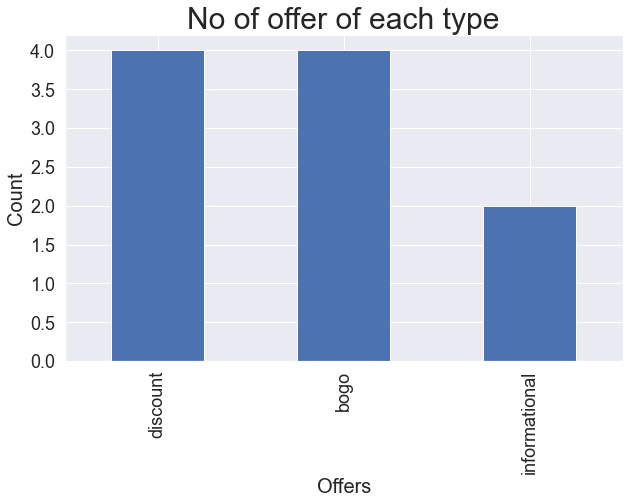

In [7]:
plt.figure(figsize=(10, 6))
portfolio['offer_type'].value_counts().plot(kind='bar', fontsize=18);
plt.xlabel('Offers', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title("No of offer of each type", fontsize=30)

Text(0.5, 1.0, 'Percentage of offer of each type')

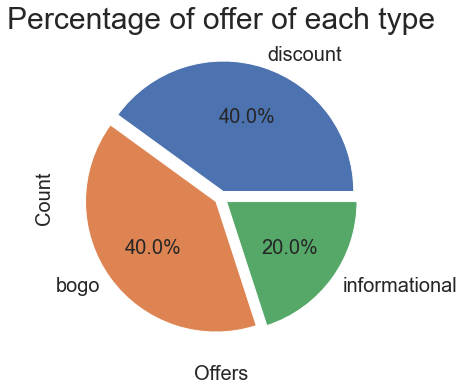

In [8]:
# precentage of offer of eacj type
plt.figure(figsize=(10, 6))
portfolio['offer_type'].value_counts().plot.pie( autopct="%.1f%%",explode=[0.05]*3, fontsize=20)
plt.xlabel('Offers', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title("Percentage of offer of each type", fontsize=30)

In [9]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Preliminary Analysis findings
1. DataFrame has 10 rows and 6 columns.
1. There is no null value in the DataFrame.
1. Multiple channels have been used to send the offer
1. There are three types of offer, Namely bogo, information, Discounts.
1. Total Number of offers are 10, out of them 4 are discounts, 4 are bogo(buy one get one free) and 2 are informational (advertisement).
1. The Rewards and Difficulty columns contains value in doller.
1. Unit of Duration is in no of days
1. column `channel`, `offer_type`, and `id` contains categorical values
***
<center><h3> DataType of each columns are shown below.</h3></center>
 
|No| Column    |Non-Null Count| Dtype |
|--|-----------|--------------|-------|
|0 | reward    |10 non-null   | int64 |
|1 | channels  |10 non-null   | object|
|2 | difficulty|10 non-null   | int64 |
|3 | duration  |10 non-null   | int64 |
|4 | offer_type|10 non-null   | object|
|5 | id        |10 non-null   | object|


## 2. Profile DataFrame

In [10]:
profile.head() # DataFrame contains information about the users.

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Some of the cells contains missing values in income and age column.

### **Shape of the profile DataFrame.**

In [11]:
print("No of rows",profile.shape[0])
print("No of columns",profile.shape[1])

No of rows 17000
No of columns 5


### DataType of each column

In [12]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

### list of columns with categorical values

In [13]:
list(profile.dtypes[profile.dtypes == 'object'].index)

['gender', 'id']

In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [15]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [16]:
profile[profile['age']==118].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

#### It looks some user's age is 118 and Value in the gender column is ```None``` and their income is also ```NaN``` . I think, It is bad data and I am not going to consider in further analysis. but, I am not removing them right now, since I have to map it to Transcript DataFrame.  and I will become a lot easier to remove them after combining two dataframes.

In [17]:
# Total No of missing value
profile.isnull().sum().sum() 

4350

### Minimum and Maximum age

In [18]:
print("Minimum age -",profile['age'].min())
print("Maximum age -",profile['age'].max())

Minimum age - 18
Maximum age - 118


### Minimum and Maximum income

In [19]:
print("Minimum income -",profile['income'].min())
print("Maximum income -",profile['income'].max())

Minimum income - 30000.0
Maximum income - 120000.0


### Creating age group column.

In [20]:
# Dividing the age into age group 
profile['age_group'] = hp.make_age_group(profile['age'])

### Preportion of the gender in profile data.

Text(0.5, 1.0, 'Preportion of each gender')

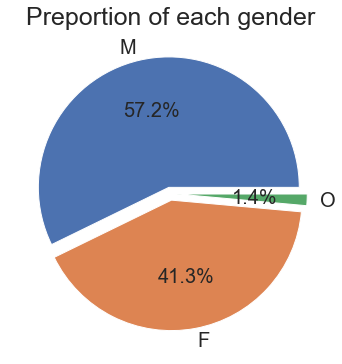

In [21]:
# Preportion of each gender in the profile DataFrame
plt.figure(figsize=(10, 6))
profile['gender'].value_counts().plot.pie( autopct="%.1f%%",explode=[0.05]*3, fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.title('Preportion of each gender', fontsize=25)

### Distribution of age in profile dataset

Text(0, 0.5, 'No of people')

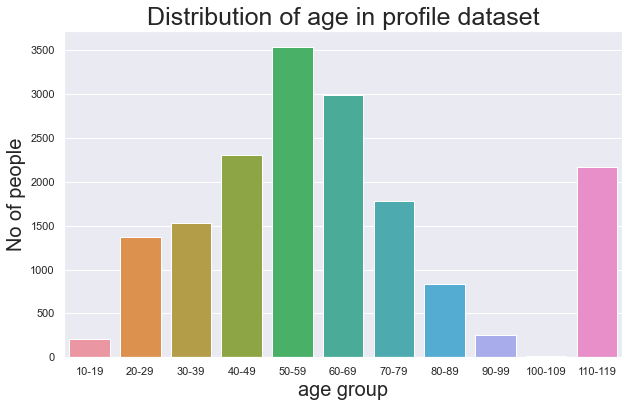

In [22]:
# Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x="age_group", data=profile.sort_values('age'))
plt.title('Distribution of age in profile dataset',fontsize=25)
plt.xlabel("age group", fontsize=20)
plt.ylabel("No of people",fontsize=20)

### Income Distribution in profile DataSet

Text(0, 0.5, 'No of people')

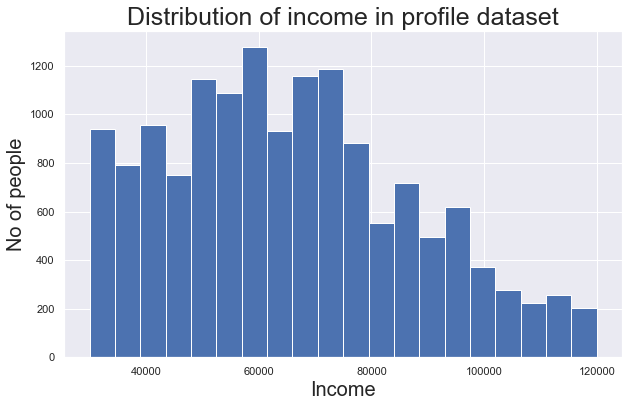

In [23]:
plt.figure(figsize=(10, 6))
profile['income'].hist(bins=20);
plt.title('Distribution of income in profile dataset',fontsize=25)
plt.xlabel("Income", fontsize=20)
plt.ylabel("No of people",fontsize=20)

## Average income based on the gender

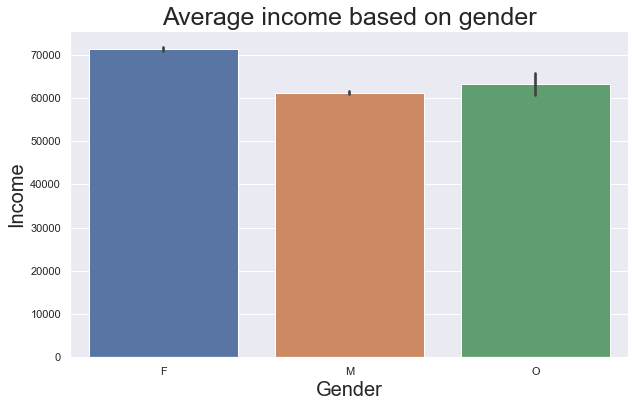

In [24]:
# What is the average income based on the gender?
plt.figure(figsize=(10, 6))
sns.barplot(x="gender", y="income", data=profile )
plt.xlabel('Gender', fontsize=20)
plt.ylabel('Income', fontsize=20)
plt.title('Average income based on gender', fontsize=25)
plt.show()

## Agerage income based on age group

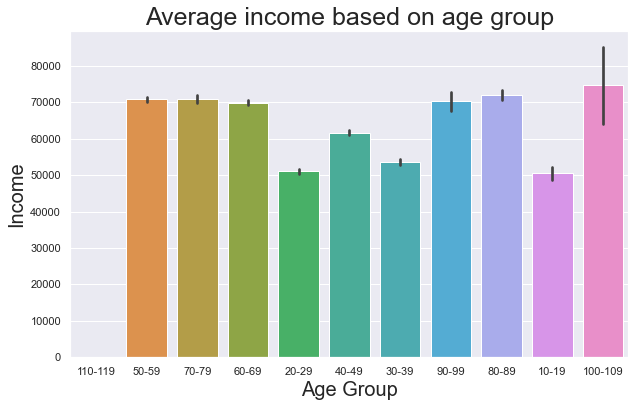

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x="age_group", y="income", data=profile)
plt.xlabel('Age Group', fontsize=20)
plt.ylabel('Income', fontsize=20)
plt.title('Average income based on age group', fontsize=25)
plt.show()

## Average income based on age group and gender

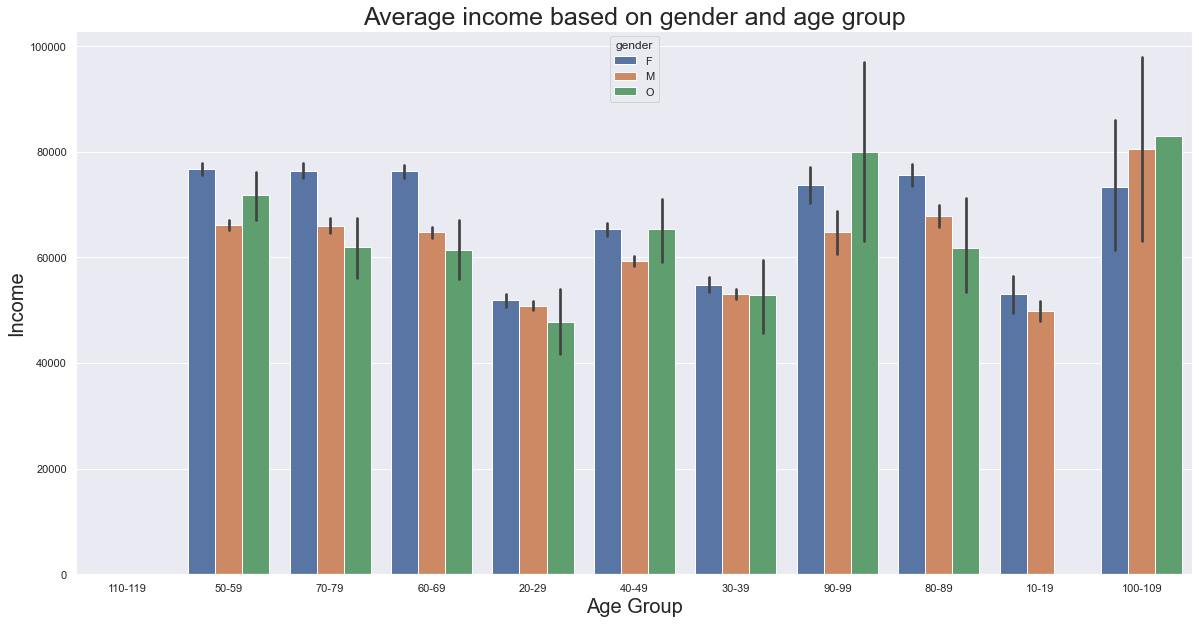

In [26]:
plt.figure(figsize=(20, 10))
sns.barplot(x="age_group", y="income",hue='gender', data=profile);
plt.xlabel('Age Group', fontsize=20)
plt.ylabel('Income', fontsize=20)
plt.title('Average income based on gender and age group', fontsize=25)
plt.show()

In [27]:
profile.head()

,gender,age,id,became_member_on,income,age_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,110-119
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,50-59
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,110-119
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,70-79
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,110-119


## Preliminary Analysis findings

1. Number of rows are `17000` and Number of columns are `5`.
1. There are `5` columns in the DataFrame.
1. Columns that contains categorical values `gender`, `id`.
1. Columns that contains missing values are `gender`,`income` and `age` ( as missing age value are encoded as 118 ).
1. DataTypes and non null count is shown below.

|No | Column          |Non-Null Count | Dtype  |
|---|-----------------|---------------|--------|
|0  |gender           |14825 non-null |object  |
|1  |age              |17000 non-null |int64   |
|2  |id               |17000 non-null |object  |
|3  |became_member_on |17000 non-null |int64   |
|4  |income           |14825 non-null |float64 |

6. Maximum value of age is `118` and Minimum value of age is `18`.
7. Maximum income is `120,000` and minimum income is `30,000`.
8. Preportion of gender `Male - 57.2%`, `Female - 41.3%` and `Others - 1.4%`

## 3. Transcript DataFrame

In [28]:
# transcript DataFrame, It contains all the information about each transection happned in 1 month time period.
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Shape of the transcript DataFrame.

In [29]:
print('Number of rows',transcript.shape[0])
print('Number of columns',transcript.shape[1])

Number of rows 306534
Number of columns 4


### data types of each column.

In [30]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [31]:
# Dtypes and Non-Null Counts of each column 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Null values in each column

In [32]:
transcript.isna().sum() # I turned out that there is no columns that contains null value.

person    0
event     0
value     0
time      0
dtype: int64

### list of columns with categorical values

In [33]:
list(transcript.dtypes[transcript.dtypes == 'object'].index)

['person', 'event', 'value']

### Count of each value in event column.

In [34]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

## BarPlot of different categories of event column

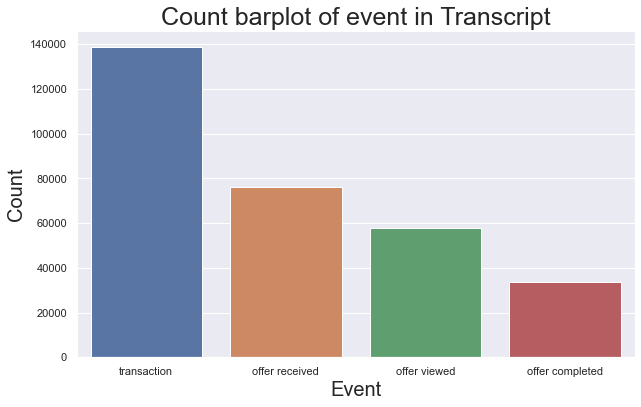

In [35]:
plt.figure(figsize=(10, 6))
hp.plot_count_barchart(transcript['event'])
plt.xlabel('Event', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Count barplot of event in Transcript', fontsize=25)
plt.show()

## Findings of Preliminary analysys


1. Shape of the Transcript Dataframe is 306534 rows and 4 columns.
1. There are four columns of the dataframe.
1. Data type of each column are

| No | Column | Non-Null Count  | Dtype |
|----|--------|-----------------|-------|
| 0  | person | 306534 non-null | object|
| 1  | event  | 306534 non-null | object|
| 2  | value  | 306534 non-null | object|
| 3  | time   | 306534 non-null | int64 |

3. There are no null values in the dataset.
4. Column that contains categorical values are ['person', 'event', 'value']
5. count of each event in transcript DataFrame are

|     event      |   count    |
|----------------|------------|
|transaction     |   138953   |
|offer received  |    76277   |
|offer viewed    |    57725   |
|offer completed |    33579   |

# Processing of the Data.

## 1. Portfolio DataFrame.

In [36]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [37]:
# Converting the duration column of portfolio to hours as time in transcript dataset is in hours
portfolio['duration'] = portfolio['duration'] * 24

#### By looking at the id column in portfolio and profile DataFrame and person column of transcript DataFrame

These are the hash value associated with to each ids by coverting it to int our further analysis would become easy

### Let's map each id to a number to make our further analysis easy. 

In [38]:
portfolio['id'], portfolio_id_map = hp.map_id_to_int(portfolio['id'])

### Creating Seperate column for channels using one hot encoding

In [39]:
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [40]:
portfolio.drop(columns='channels',inplace=True)

In [41]:
portfolio.rename(columns={'id':'offer_id','reward':'offer_reward'},inplace=True)

### Portfolio DataFrame after some feature engineering

In [42]:
portfolio

,offer_reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,168,bogo,1,1,1,1,0
1,10,10,120,bogo,2,1,1,1,1
2,0,0,96,informational,3,1,1,0,1
3,5,5,168,bogo,4,1,1,0,1
4,5,20,240,discount,5,1,0,0,1
5,3,7,168,discount,6,1,1,1,1
6,2,10,240,discount,7,1,1,1,1
7,0,0,72,informational,8,1,1,1,0
8,5,5,120,bogo,9,1,1,1,1
9,2,10,168,discount,10,1,1,0,1


In [43]:
channel_count = portfolio[['channel_email','channel_mobile','channel_social','channel_web']].sum()

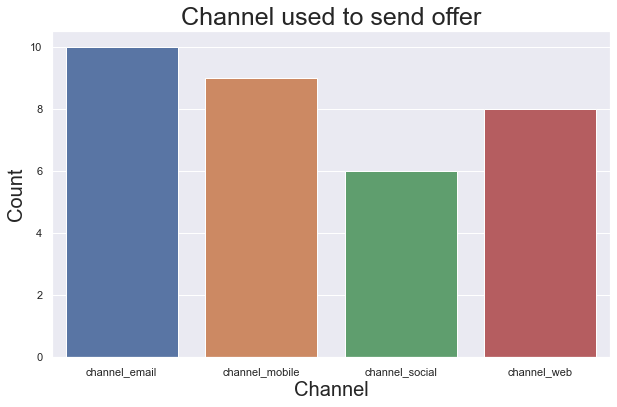

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(x=channel_count.index,y=channel_count.values)
plt.xlabel('Channel', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Channel used to send offer', fontsize=25)
plt.show()

## 2. Profile DataFrame

In [45]:
profile.head()

,gender,age,id,became_member_on,income,age_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,110-119
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,50-59
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,110-119
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,70-79
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,110-119


### Mapping each hash to an int id.

In [46]:
## Let's map id hash value of profile dataframe to an integer to make further analysis easy.
profile['id'] , profile_id_map = hp.map_id_to_int(profile['id'])

Creating the age group of interval 10

### Dividing the age into age group

In [47]:
profile['age_group'] = hp.make_age_group(profile['age'])

### Changing the DataType of become_member_on column to DataTime

In [48]:

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

In [49]:
# Renaming the id column to person_id
profile.rename(columns={'id':'user_id'},inplace=True)

### Creating an Income group

In [50]:
# dividing data based on income into three category ['low','average','high']
profile['income_group'] = hp.make_income_group(profile['income']) # Function to put each income value into a group

In [51]:
# Creating a column based on the year in which user become member
profile['become_member_in'] = profile['became_member_on'].dt.year

In [52]:
profile.head()

,gender,age,user_id,became_member_on,income,age_group,income_group,become_member_in
0,None,118,1,2017-02-12,NaN,110-119,nan,2017
1,F,55,2,2017-07-15,112000.0,50-59,High,2017
2,None,118,3,2018-07-12,NaN,110-119,nan,2018
3,F,75,4,2017-05-09,100000.0,70-79,High,2017
4,None,118,5,2017-08-04,NaN,110-119,nan,2017


## 3. Transcript DataFrame

In [53]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Mapping each hash user id to an int.

In [54]:
# As I have maped the hash id in profile dataframe to an integer,
# I'll have to use that same hash id to int map  to map with tanscript['person'] series
transcript['person'], _  = hp.map_id_to_int(transcript['person'], profile_id_map)

### Renaming person column to user_id

In [55]:
transcript.rename(columns={'person':'user_id'},inplace=True)

In [56]:
transcript.head()

,user_id,event,value,time
0,4,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,5,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,6,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,7,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,8,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Creating the seperate column depending on event from value Column.

In [57]:
# Creating the seperate column depending on event from value Column

transcript['offer_id'] = transcript['value'].apply(lambda x :  x.get('offer id') 
                                                   if (list(x.keys())[0] == 'offer id') 
                                                   else x.get('offer_id'))

transcript['amount'] = transcript['value'].apply(lambda x : x.get('amount'))

transcript['reward'] = transcript['value'].apply(lambda x : x.get('reward'))

### Droping value column

In [58]:
transcript.drop(columns='value',inplace=True)

In [59]:
transcript.head()

,user_id,event,time,offer_id,amount,reward
0,4,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,5,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,6,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,7,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,8,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### Mapping each hash of offer id to its int id.

In [60]:
# As I have maped the hash id in portfolio dataframe to an integer,
# I'll have to use that same hash id to int map  to map with tanscript['offer_id'] series
transcript['offer_id'], _ = hp.map_id_to_int(transcript['offer_id'], portfolio_id_map)

In [61]:
transcript.head()

,user_id,event,time,offer_id,amount,reward
0,4,offer received,0,4.0,NaN,NaN
1,5,offer received,0,5.0,NaN,NaN
2,6,offer received,0,10.0,NaN,NaN
3,7,offer received,0,7.0,NaN,NaN
4,8,offer received,0,2.0,NaN,NaN


### Let's Merge all the DataFrames to one big DataFrame

In [62]:
df = pd.merge(pd.merge(transcript,profile,on='user_id'),portfolio,on='offer_id',how='left')
df.head()

,user_id,event,time,offer_id,amount,reward,gender,age,became_member_on,income,...,income_group,become_member_in,offer_reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,4,offer received,0,4.0,NaN,NaN,F,75,2017-05-09,100000.0,...,High,2017,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
1,4,offer viewed,6,4.0,NaN,NaN,F,75,2017-05-09,100000.0,...,High,2017,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
2,4,transaction,132,NaN,19.89,NaN,F,75,2017-05-09,100000.0,...,High,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,offer completed,132,4.0,NaN,5.0,F,75,2017-05-09,100000.0,...,High,2017,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
4,4,transaction,144,NaN,17.78,NaN,F,75,2017-05-09,100000.0,...,High,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# Removing all the user with age 118
# As I am considering the all the user with age as 118 as an outlier.
df = df[df['age'] != 118] 

In [64]:
df.head()

,user_id,event,time,offer_id,amount,reward,gender,age,became_member_on,income,...,income_group,become_member_in,offer_reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,4,offer received,0,4.0,NaN,NaN,F,75,2017-05-09,100000.0,...,High,2017,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
1,4,offer viewed,6,4.0,NaN,NaN,F,75,2017-05-09,100000.0,...,High,2017,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
2,4,transaction,132,NaN,19.89,NaN,F,75,2017-05-09,100000.0,...,High,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,offer completed,132,4.0,NaN,5.0,F,75,2017-05-09,100000.0,...,High,2017,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
4,4,transaction,144,NaN,17.78,NaN,F,75,2017-05-09,100000.0,...,High,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df['end_time'] = df['time'] + df['duration']

## Splitting the DataFrame Based on the events

In [66]:
# Splitting the DataFrame Based on the events
df_offer_received = df[df['event'] == 'offer received'].sort_values(['user_id','time']).copy()
df_offer_viewed = df[df['event'] == 'offer viewed'].sort_values(['user_id','time']).copy()
df_transaction = df[df['event'] == 'transaction'].sort_values(['user_id','time']).copy()
df_transaction = df_transaction.drop('end_time',axis=1)
df_offer_completed = df[df['event'] == 'offer completed'].sort_values(['user_id','time']).copy()
df_offer_completed = df_offer_completed.drop('end_time',axis=1)


As our main focus is on which group of people are more responsive to each type of offer, we are going to take `offer viewed`and `offer completed` columns into consideration.

<!-- As a Customer can complete an offer without viewing the offer, it means they are not influenced by the offer, so I am going to remove the user who are in `df_offer_completed` but not in `df_offer_viewed`. -->

# Analysis

# 1. Analysis based on age group.

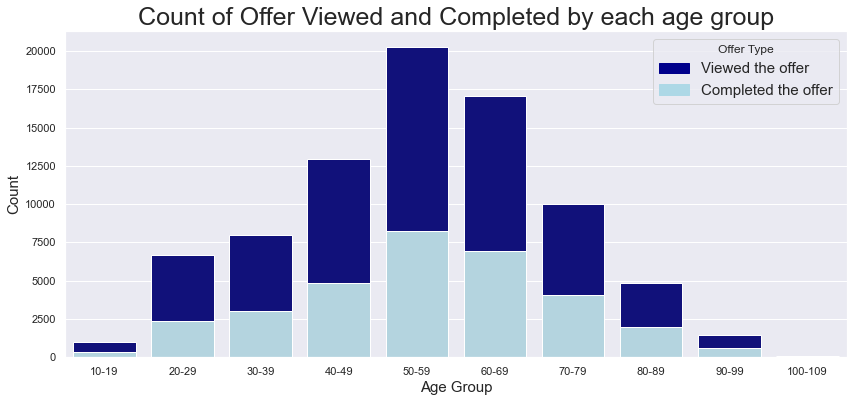

In [67]:

plt.figure(figsize=(14, 6))
plt1 = sns.countplot(x='age_group',data=pd.concat([df_offer_viewed[['age_group','age']],
                                                   df_offer_completed[['age_group','age']]]).sort_values('age'), 
                     color='darkblue')
plt2 = sns.countplot(x="age_group", data=df_offer_completed.sort_values('age'),  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Viewed the offer')
bottom_bar = mpatches.Patch(color='lightblue', label='Completed the offer')


plt.title('Count of Offer Viewed and Completed by each age group',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Age Group',fontsize=15)
plt.legend(title='Offer Type',fontsize=15,handles=[top_bar, bottom_bar])
plt.show()

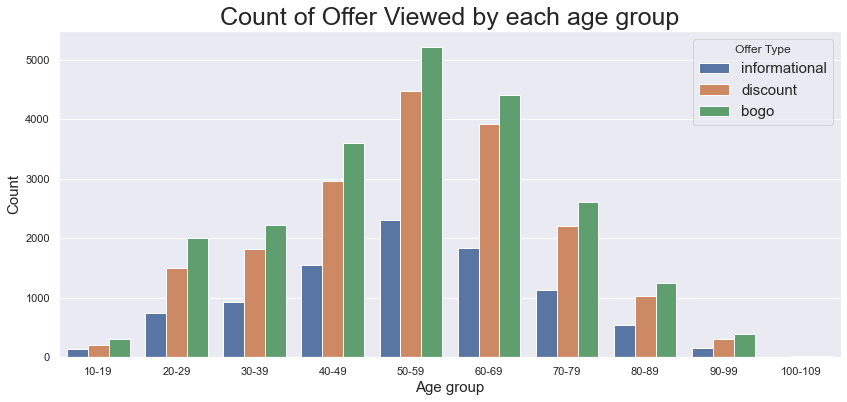

In [68]:
plt.figure(figsize=(14, 6)) # Count of each people vs which offer has been viewed how many times
sns.countplot(x="age_group", hue="offer_type", data=df_offer_viewed.sort_values('age'));
plt.title('Count of Offer Viewed by each age group',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Age group',fontsize=15)
plt.legend(title='Offer Type',fontsize=15)
plt.show()

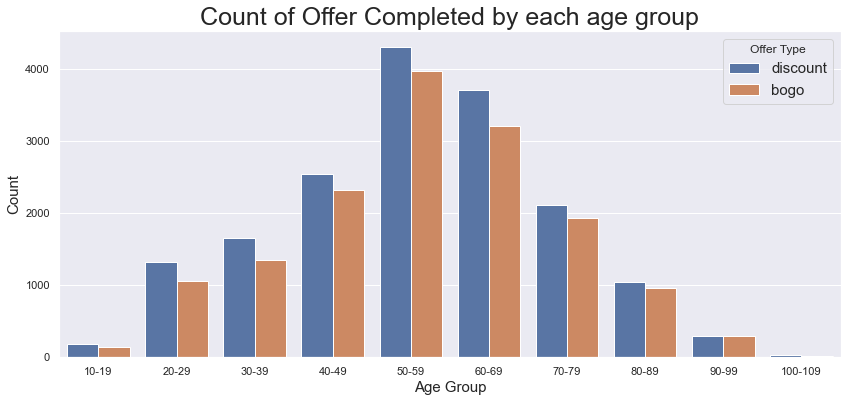

In [69]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_group",hue='offer_type', data=df_offer_completed.sort_values('age'))
plt.title('Count of Offer Completed by each age group',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Age Group',fontsize=15)
plt.legend(title='Offer Type',fontsize=15)
plt.show()

# 2. Analysis based on gender

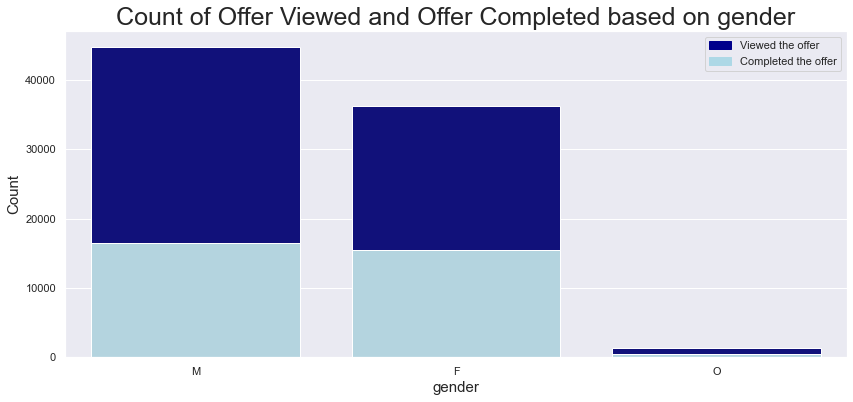

In [70]:
plt.figure(figsize=(14, 6))

plt1 = sns.countplot(x="gender",  data=pd.concat([df_offer_viewed[['gender','age']],
                                                   df_offer_completed[['gender','age']]]).sort_values('age'), color='darkblue')
plt2 = sns.countplot(x="gender", data=df_offer_completed.sort_values('age'),  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Viewed the offer')
bottom_bar = mpatches.Patch(color='lightblue', label='Completed the offer')
plt.legend(handles=[top_bar, bottom_bar])


plt.title('Count of Offer Viewed and Offer Completed based on gender',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('gender',fontsize=15)
# plt.legend(title='Offer Type',fontsize=15)
plt.show()

## Offer viewed based on Gender

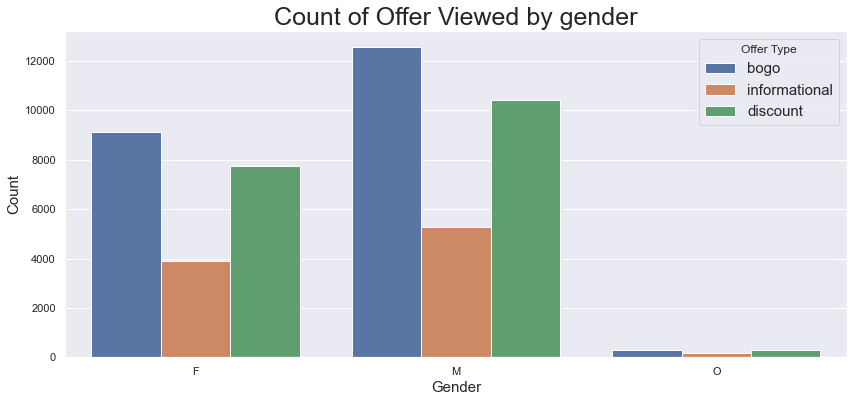

In [71]:
plt.figure(figsize=(14, 6)) # Count of each people based on gender vs which offer has been viewed how many times
sns.countplot(x="gender", hue="offer_type", data=df_offer_viewed);
plt.title('Count of Offer Viewed by gender',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Gender',fontsize=15)
plt.legend(title='Offer Type',fontsize=15)
plt.show()

## Offer Completed Based on gender

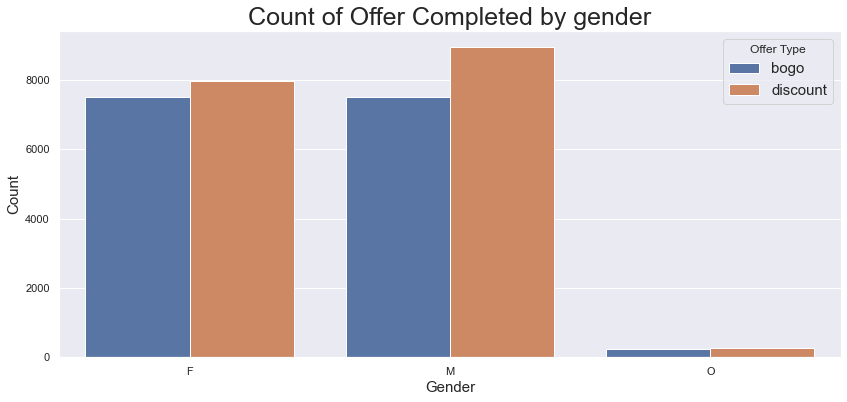

In [72]:
plt.figure(figsize=(14, 6))
sns.countplot(x="gender",hue='offer_type', data=df_offer_completed)
plt.title('Count of Offer Completed by gender',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Gender',fontsize=15)
plt.legend(title='Offer Type',fontsize=15)
plt.show()

# 3. Analysis based on income.

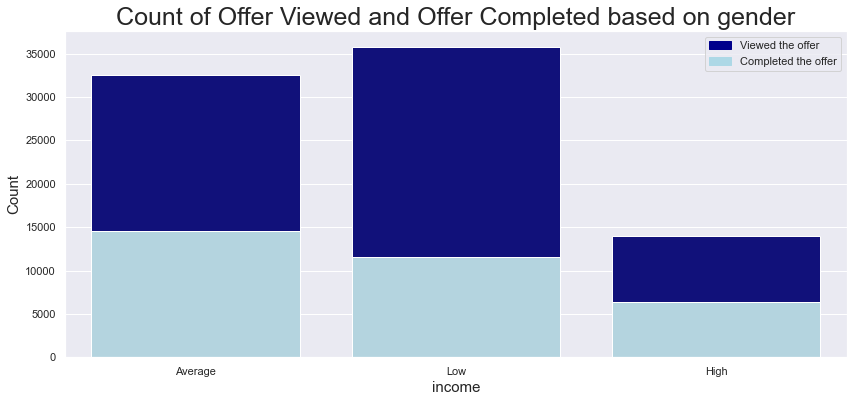

In [73]:
plt.figure(figsize=(14, 6))

plt1 = sns.countplot(x="income_group",  data=pd.concat([df_offer_viewed[['income_group','age']],
                                                   df_offer_completed[['income_group','age']]]).sort_values('age'), color='darkblue')
plt2 = sns.countplot(x="income_group", data=df_offer_completed.sort_values('age'),  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Viewed the offer')
bottom_bar = mpatches.Patch(color='lightblue', label='Completed the offer')
plt.legend(handles=[top_bar, bottom_bar])


plt.title('Count of Offer Viewed and Offer Completed based on gender',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('income',fontsize=15)
# plt.legend(title='Offer Type',fontsize=15)
plt.show()

## Offer viewed based on Income group

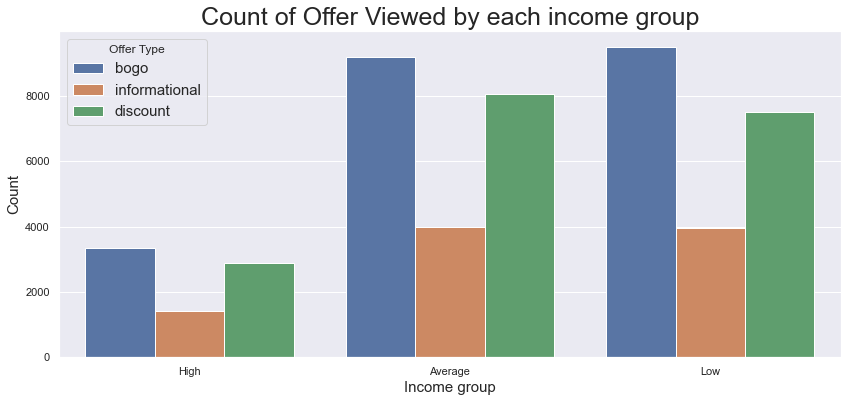

In [74]:
plt.figure(figsize=(14, 6)) # Count of each people vs which offer has been viewed how many times
sns.countplot(x="income_group", hue="offer_type", data=df_offer_viewed);
plt.title('Count of Offer Viewed by each income group',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Income group',fontsize=15)
plt.legend(title='Offer Type',fontsize=15)
plt.show()

## Offer Completed based on income group

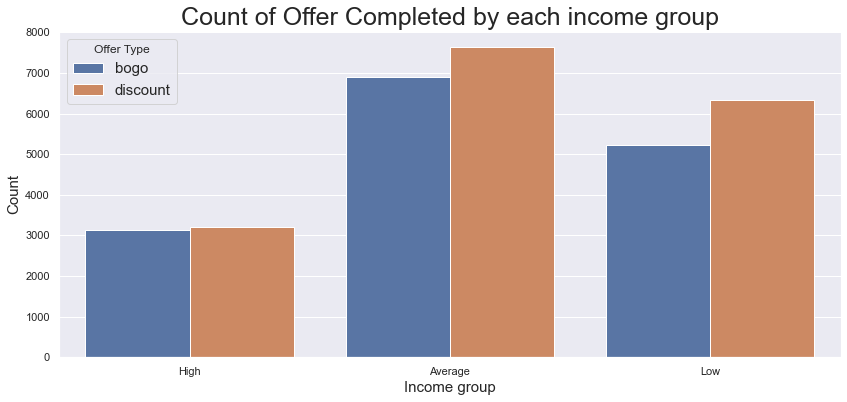

In [75]:
plt.figure(figsize=(14, 6)) # Count of each people vs which offer has been viewed how many times
sns.countplot(x="income_group", hue="offer_type", data=df_offer_completed);
plt.title('Count of Offer Completed by each income group',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Income group',fontsize=15)
plt.legend(title='Offer Type',fontsize=15)
plt.show()

# 4. Analysis based on become member in.

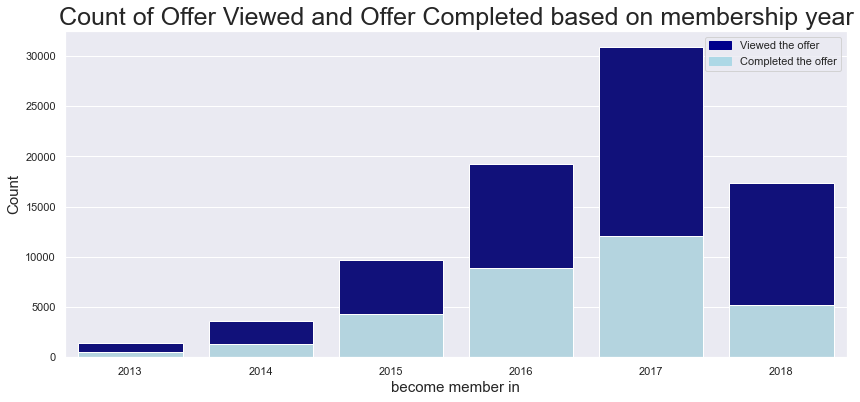

In [76]:
plt.figure(figsize=(14, 6))

plt1 = sns.countplot(x="become_member_in",  data=pd.concat([df_offer_viewed[['become_member_in','age']],
                                                   df_offer_completed[['become_member_in','age']]]).sort_values('age'), color='darkblue')
plt2 = sns.countplot(x="become_member_in", data=df_offer_completed.sort_values('age'),  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Viewed the offer')
bottom_bar = mpatches.Patch(color='lightblue', label='Completed the offer')
plt.legend(handles=[top_bar, bottom_bar])


plt.title('Count of Offer Viewed and Offer Completed based on membership year',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('become member in',fontsize=15)
# plt.legend(title='Offer Type',fontsize=15)
plt.show()

## Offer Viewed Based on MemberShip Year

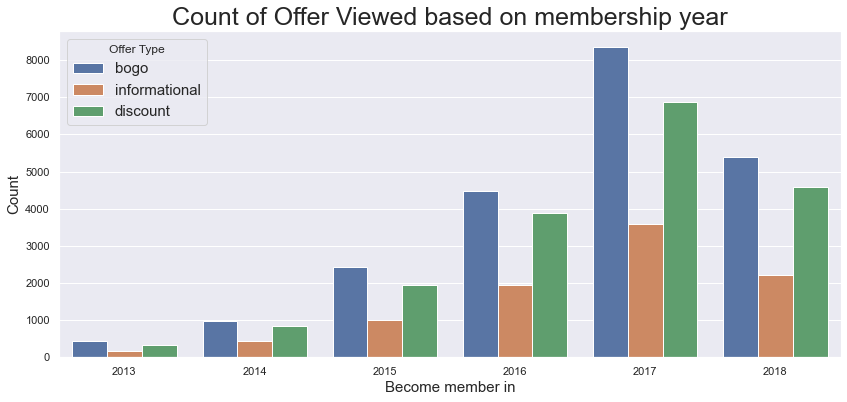

In [77]:
plt.figure(figsize=(14, 6)) # Count of each people based on gender vs which offer has been viewed how many times
sns.countplot(x="become_member_in", hue="offer_type", data=df_offer_viewed);
plt.title('Count of Offer Viewed based on membership year',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Become member in',fontsize=15)
plt.legend(title='Offer Type',fontsize=15)
plt.show()

## offer completed based on membership year

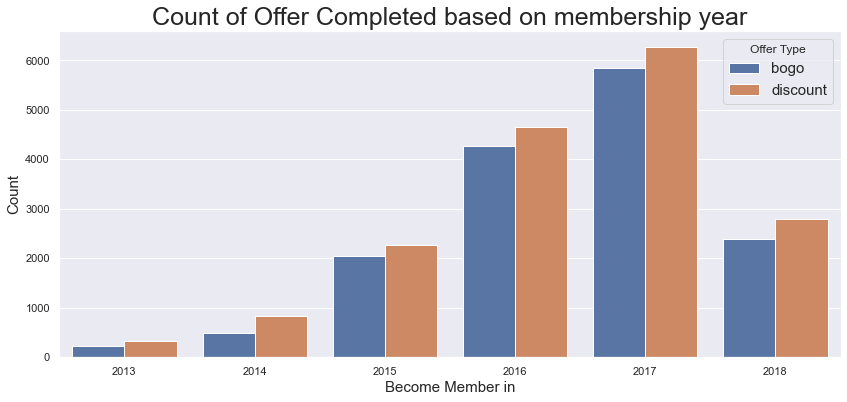

In [78]:
plt.figure(figsize=(14, 6))
sns.countplot(x="become_member_in",hue='offer_type', data=df_offer_completed)
plt.title('Count of Offer Completed based on membership year',fontsize=25)
plt.ylabel('Count',fontsize=15)
plt.xlabel('Become Member in',fontsize=15)
plt.legend(title='Offer Type',fontsize=15)
plt.show()